##### Copyright 2023 Google LLC.

Licensed under the Apache License, Version 2.0 (the "License");

In [ ]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Utility decision diagrams: Introduction

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/google-research/r_u_sure/r_u_sure/notebooks/Utility_decision_diagrams_intro.ipynb)

This notebook gives an introduction to representing edit-distance-based utility functions as decision diagrams, and using them to solve for high-utility suggestions.

For details on the actual utility functions used in the paper, see the companion notebook [`Utility_decision_diagrams_details.ipynb`](https://colab.research.google.com/github/google-research/r_u_sure/r_u_sure/notebooks/Utility_decision_diagrams_details.ipynb).

## Setup

### Installation

To run this notebook, you need a Python environment with `r_u_sure` installed. 

If you are running this from Colab, you can install it by running the following command:

In [ ]:
try:
  import r_u_sure
except ImportError:
  try:
    import google.colab
    in_colab = True
  except ImportError:
    in_colab = False
  
  if in_colab:
    print("Installing r_u_sure from GitHub...")
    %env NUMBA_DISABLE_TBB=1
    %env NUMBA_DISABLE_OPENMP=1
    !pip install "r_u_sure @ git+https://github.com/google-research/r_u_sure"
  else:
    # Don't install in this case, to avoid messing up the python environment.
    print("WARNING: Not running in Colab and r_u_sure not found. "
          "Please install r_u_sure following the instructions in the README.")
    raise

### Imports

In [ ]:
import enum
import numpy as np
import typing
import pprint
import matplotlib.pyplot as plt

In [ ]:
from IPython import display

In [ ]:
from r_u_sure.decision_diagrams import gated_state_dag
from r_u_sure.decision_diagrams import packed_dags
from r_u_sure.decision_diagrams import consistent_path_dual_solver

from r_u_sure.rendering import dag_annotator
from r_u_sure.rendering import rendering
from r_u_sure.rendering import svg_renderer
from r_u_sure.rendering import simple_dag_annotator
from r_u_sure.rendering import render_in_notebook

## Calculating utility based on edit distance

Our utility functions are based on confidence-adjusted edit distance: suggestions that are easier to edit have higher utility, and identifying the edited regions as uncertain makes them easier to edit.

Here's an implementation of the simplified utility function described in Algorithm 1 of the paper. It takes two arguments: a suggestion, which has tokens tagged with confidence, and a user intent, which represents what the user is trying to write.

In [ ]:
class Confidence(enum.Enum):
  SURE = 0
  UNSURE = 1

def simple_edit_distance_utility(
    target: list[str],
    suggestion: list[tuple[str, Confidence]],
) -> float:
  """Computes the utility of `suggestion` for a user with intent `target`.

  This implements Algorithm 1 in Figure 3 of our paper, and is a variant of
  the dynamic programming algorithm for edit distance.
  (See also https://en.wikipedia.org/wiki/Wagner%E2%80%93Fischer_algorithm)

  Args:
    target: A list of tokens that the user actually wants to write.
    suggestion: A list of pairs (token, confidence) that we can show.
  
  Returns:
    Confidence-adjusted utility of showing `suggestion` to a user who wants
    to write `target`.
  """
  m = len(target)
  n = len(suggestion)
  table = np.full((m + 1, n + 1), -np.inf)
  table[0,0] = 0.0  # Base case for dynamic programming
  for i in range(m + 1):
    for j in range(n + 1):
      if i > 0:
        # Insert target[i - 1].
        # Utility of inserts is 0, because we didn't save any effort here.
        table[i, j] = max(table[i, j], table[i - 1, j] + 0)

      if j > 0:
        # Delete suggestion[j - 1].
        suggestion_token, confidence = suggestion[j - 1]
        if confidence == Confidence.SURE:
          # Penalty of 1 for deleting a SURE token.
          table[i, j] = max(table[i, j], table[i, j - 1] - 1)
        elif confidence == Confidence.UNSURE:
          # Penalty of 0.3 for deleting an UNSURE token.
          table[i, j] = max(table[i, j], table[i, j - 1] - 0.3)
      
      if i > 0 and j > 0:
        target_token = target[i - 1]
        suggestion_token, confidence = suggestion[j - 1]
        if target_token == suggestion_token:
          # Match suggestion[j - 1] and target[i - 1].
          if confidence == Confidence.SURE:
            # Reward of 1 for matching a SURE token.
            table[i, j] = max(table[i, j], table[i - 1, j - 1] + 1)
          elif confidence == Confidence.UNSURE:
            # Reward of 0.7 for matching an UNSURE token.
            table[i, j] = max(table[i, j], table[i - 1, j - 1] + 0.7)
  
  return table[m, n]


We can use this to compare the utility of different suggestions, given a fixed user intent.

In [ ]:
# Utility of a matching, confident suggestion
simple_edit_distance_utility(
    target=["one", "two", "three"],
    suggestion=[("one", Confidence.SURE),
                ("two", Confidence.SURE),
                ("three", Confidence.SURE)],
)

3.0

In [ ]:
# Utility of a matching suggestion with an unsure token
simple_edit_distance_utility(
    target=["one", "two", "three"],
    suggestion=[("one", Confidence.SURE),
                ("two", Confidence.UNSURE),
                ("three", Confidence.SURE)],
)

2.7

In [ ]:
# Utility of a suggestion with one token missing
simple_edit_distance_utility(
    target=["one", "two", "three"],
    suggestion=[("one", Confidence.SURE),
                ("three", Confidence.SURE)],
)

2.0

In [ ]:
# Utility of a suggestion with a confident error
simple_edit_distance_utility(
    target=["one", "two", "three"],
    suggestion=[("one", Confidence.SURE),
                ("three", Confidence.SURE),
                ("four", Confidence.SURE),],
)

1.0

In [ ]:
# Utility of a suggestion with an unsure error
simple_edit_distance_utility(
    target=["one", "two", "three"],
    suggestion=[("one", Confidence.SURE),
                ("three", Confidence.SURE),
                ("four", Confidence.UNSURE),],
)

1.7

Different user intents lead to different utility estimates. If we aren't sure what a user's intent is, we can try to average the utility of our suggestions over multiple intents.

As a simple example, if we aren't sure about a particular part of a suggestion, marking that part as uncertain will increase average utility.

In [ ]:
def average_utility_across_possible_targets(
    targets: list[list[str]],
    suggestion: list[tuple[str, Confidence]],
) -> float:
  """Averages utility across a number of possible targets."""
  total = 0
  for i, target in enumerate(targets):
    utility = simple_edit_distance_utility(target, suggestion)
    print(f"Utility for target {i}: {utility}")
    total += utility
  
  return total / len(targets)

In [ ]:
# Making a confident guess when possible intents differ leads to suboptimal
# utility, due to the penalty for being wrong on two out of three targets.
average_utility_across_possible_targets(
    targets=[
        ["one", "two", "three"],
        ["one", "four", "three"],
        ["one", "five", "three"],
    ],
    suggestion=[
        ("one", Confidence.SURE),
        ("two", Confidence.SURE),
        ("three", Confidence.SURE),
    ]
)

Utility for target 0: 3.0
Utility for target 1: 1.0
Utility for target 2: 1.0


1.6666666666666667

In [ ]:
# Making a less confident guess about an uncertain part increases utility
# on average (with a slight penalty to target 0 but larger gains for the other
# targets)
average_utility_across_possible_targets(
    targets=[
        ["one", "two", "three"],
        ["one", "four", "three"],
        ["one", "five", "three"],
    ],
    suggestion=[
        ("one", Confidence.SURE),
        ("two", Confidence.UNSURE),
        ("three", Confidence.SURE),
    ]
)

Utility for target 0: 2.7
Utility for target 1: 1.7
Utility for target 2: 1.7


2.0333333333333337

In [ ]:
# But being too underconfident about everything lowers utility.
average_utility_across_possible_targets(
    targets=[
        ["one", "two", "three"],
        ["one", "four", "three"],
        ["one", "five", "three"],
    ],
    suggestion=[
        ("one", Confidence.UNSURE),
        ("two", Confidence.UNSURE),
        ("three", Confidence.UNSURE),
    ]
)

Utility for target 0: 2.0999999999999996
Utility for target 1: 1.0999999999999999
Utility for target 2: 1.0999999999999999


1.433333333333333

## Representing our utility as a decision diagram

Although this version of our utility function allows us to easily compute the utility of a fixed suggestion, it doesn't let us efficiently search for the locations of uncertain regions in that suggestion. We can instead rewrite it to build a decision diagram, allowing us to search efficiently using dynamic programming.

To do this, we first have to define a few things:

- A type representing a "state" in the decision diagram. This roughly corresponds to an entry in a dynamic programming algorithm, or to an intermediate state of someone editing the suggestion when going left to right. In this case, we can use a tuple of positions, one for the suggestion and one for the target intent.
- A type representing a "decision key". This identifies a specific decision that we need to make.
- A type representing a "decision value". The optimization algorithm will assign a value to each decision key.

In [ ]:
class State(typing.NamedTuple):
  """A state in our decision diagram."""
  index_in_target: int
  index_in_suggestion: int

  def __str__(self):
    return f"State({self.index_in_target}, {self.index_in_suggestion})"

class TokenConfidenceDecision(typing.NamedTuple):
  """Decision key for deciding confidence for each token."""
  # The location of the token we are deciding the confidence of.
  index_of_token_in_suggestion: int

  def __str__(self):
    return f"c_{self.index_of_token_in_suggestion}"

class DecisionValue(enum.Enum):
  """A value for each decision."""
  # Confidence levels
  SURE = 0
  UNSURE = 1
  # Extra value for an invalid assignment
  NOT_APPLICABLE = 2

  def __str__(self):
    return self.name

We can then implement our utility function as a decision diagram builder. This takes a suggestion *prototype* (a suggestion without any confidence annotations) along with a target intent, and constructs a diagram by adding edges. Each edge has a *cost* (the negative of utility) and optionally a *required assignment*, specifying the decision that needs to be taken in order to use this edge. There is also a designated start and end state.

(Note: Although our paper describes everything in terms of maximizing utility, our implementation is written in terms of minimizing costs. This is equivalent, and the "cost" of a useful suggestion is usually negative.)

In [ ]:
def build_simple_edit_distance_utility_diagram(
    target: list[str],
    suggestion_prototype: list[str],
) -> gated_state_dag.CompleteStateDAG:
  """Builds a diagram for searching over confidence annotations.
  
  This implements Algorithm 2 in Figure 3 of our paper.

  Args:
    target: A list of tokens that the user actually wants to write.
    suggestion_prototype: A list of tokens that we want to show in a suggestion,
      without confidence annotations. We will add confidence annotations by
      searching over the diagram produced by this function.
  
  Returns:
    A decision diagram such that the total cost of any path from the
    initial_state to the final_state is equal to the negative utility of the
    corresponding suggestion under `simple_edit_distance_utility`.
  """
  m = len(target)
  n = len(suggestion_prototype)
  # Initialize an empty decision diagram, starting from (0,0)
  diagram = gated_state_dag.partial_state_dag_starting_from(State(0, 0))

  for i in range(m + 1):
    for j in range(n + 1):

      if i > 0:
        # Insert target[i - 1].
        # Utility of inserts is 0, because we didn't save any effort here.
        target_token = target[i - 1]
        gated_state_dag.partial_state_dag_add_edge(
            diagram,
            gated_state_dag.Edge(
                source=State(i - 1, j),
                dest=State(i, j),
                cost=0.0,
                required_assignment=None,
                info={
                    "description": f"insert target[{i-1}] {repr(target_token)}",
                    "color": "blue",
                },
            ),
        )
      
      if j > 0:
        # Delete suggestion[j - 1].
        suggestion_token = suggestion_prototype[j - 1]
        # Penalty of 1 for deleting a SURE token.
        gated_state_dag.partial_state_dag_add_edge(
            diagram,
            gated_state_dag.Edge(
                source=State(i, j - 1),
                dest=State(i, j),
                cost=1.0,
                required_assignment=gated_state_dag.SharedVariableAssignment(
                    key=TokenConfidenceDecision(j - 1),
                    value=DecisionValue.SURE,
                ),
                info={
                    "description": f"delete suggestion[{i-1}] ({repr(suggestion_token)}, SURE)",
                    "color": "red",
                },
            ),
        )
        # Penalty of 0.3 for deleting an UNSURE token.
        gated_state_dag.partial_state_dag_add_edge(
            diagram,
            gated_state_dag.Edge(
                source=State(i, j - 1),
                dest=State(i, j),
                cost=0.3,
                required_assignment=gated_state_dag.SharedVariableAssignment(
                    key=TokenConfidenceDecision(j - 1),
                    value=DecisionValue.UNSURE,
                ),
                info={
                    "description": f"delete suggestion[{i-1}] ({repr(suggestion_token)}, UNSURE)",
                    "color": "darkred",
                },
            ),
        )
    
      if i > 0 and j > 0:
        target_token = target[i - 1]
        suggestion_token = suggestion_prototype[j - 1]
        if target_token == suggestion_token:
          # Match suggestion[j - 1] and target[i - 1].
          # Reward of 1 for matching a SURE token.
          gated_state_dag.partial_state_dag_add_edge(
              diagram,
              gated_state_dag.Edge(
                  source=State(i - 1, j - 1),
                  dest=State(i, j),
                  cost=-1.0,
                  required_assignment=gated_state_dag.SharedVariableAssignment(
                      key=TokenConfidenceDecision(j - 1),
                      value=DecisionValue.SURE,
                  ),
                  info={
                    "description": f"match target[{j-1}] and suggestion[{i-1}] ({repr(suggestion_token)}, SURE)",
                    "color": "limegreen",
                  },
              ),
          )
          # Reward of 0.7 for matching an UNSURE token.
          gated_state_dag.partial_state_dag_add_edge(
              diagram,
              gated_state_dag.Edge(
                  source=State(i - 1, j - 1),
                  dest=State(i, j),
                  cost=-0.7,
                  required_assignment=gated_state_dag.SharedVariableAssignment(
                      key=TokenConfidenceDecision(j - 1),
                      value=DecisionValue.UNSURE,
                  ),
                  info={
                    "description": f"match target[{j - 1}] and suggestion[{i-1}] ({repr(suggestion_token)}, UNSURE)",
                    "color": "darkgreen",
                  },
              ),
          )

  return gated_state_dag.partial_state_dag_finish(diagram, State(m, n))


It's sometimes useful to visualize the built diagram. To do this, we can use an "annotator" object, which describes how different states should be rendered. Here we're subclassing a base annotator with some reasonable heuristic defaults. (The utility functions we use for the paper have more specialized annotators.)

In [ ]:
class SimpleUtilityDiagramAnnotator(simple_dag_annotator.SimpleDAGAnnotator):
  def bounds_for_state(self, state: State) -> rendering.BoundingBox:
    return rendering.BoundingBox(
        left=state.index_in_suggestion * 200,
        top=state.index_in_target * 120,
        width=50,
        height=90,
    )

Here's the diagram for the suggestion prototype and target visualized in Figure 3 of the paper. Try hovering over the edges or states with your mouse for a few seconds to reveal more information.

In [ ]:
diagram = build_simple_edit_distance_utility_diagram(
    target=["a", "c", "b", "d"],
    suggestion_prototype=["a", "b", "c"],
)

In [ ]:
render_in_notebook.render_dag_in_notebook(
    dag=diagram,
    annotator=SimpleUtilityDiagramAnnotator(),
)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Here's a diagram for one of the pairs of target and suggestion we computed utility for in the previous section:

In [ ]:
diagram = build_simple_edit_distance_utility_diagram(
    target=["one", "four", "three"],
    suggestion_prototype=["one", "two", "three"],
)

In [ ]:
render_in_notebook.render_dag_in_notebook(
    dag=diagram,
    annotator=SimpleUtilityDiagramAnnotator(),
)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Preprocessing the diagram

To enable efficient processing downstream, we convert our diagram into a "packed" form, a collection of Numpy arrays. All of the states, decision keys, and decision values are rewritten as integer indices.

In [ ]:
diagram = build_simple_edit_distance_utility_diagram(
    target=["one", "four", "three"],
    suggestion_prototype=["one", "two", "three"],
)

In [ ]:
reachable_subdag = gated_state_dag.prune_to_reachable(diagram)
packed_dag, conversion_data = packed_dags.convert_dag_to_packed(
    reachable_subdag,
    missing_assignment_value=DecisionValue.NOT_APPLICABLE,
    variable_value_ordering=[
        DecisionValue.SURE, DecisionValue.UNSURE, DecisionValue.NOT_APPLICABLE
    ],
)

In [ ]:
packed_dag

PackedStateDAG(num_tagged_states=16, num_variable_keys=3, num_variable_values=3, packed_edge_matrix=array([( 0,  1,  0. , -1, -1), ( 1,  2,  0. , -1, -1),
       ( 2,  3,  0. , -1, -1), ( 0,  4,  1. ,  0,  0),
       ( 0,  4,  0.3,  0,  1), ( 0,  5, -1. ,  0,  0),
       ( 0,  5, -0.7,  0,  1), ( 1,  5,  1. ,  0,  0),
       ( 1,  5,  0.3,  0,  1), ( 2,  6,  1. ,  0,  0),
       ( 2,  6,  0.3,  0,  1), ( 3,  7,  1. ,  0,  0),
       ( 3,  7,  0.3,  0,  1), ( 4,  5,  0. , -1, -1),
       ( 5,  6,  0. , -1, -1), ( 6,  7,  0. , -1, -1),
       ( 4,  8,  1. ,  1,  0), ( 4,  8,  0.3,  1,  1),
       ( 5,  9,  1. ,  1,  0), ( 5,  9,  0.3,  1,  1),
       ( 6, 10,  1. ,  1,  0), ( 6, 10,  0.3,  1,  1),
       ( 7, 11,  1. ,  1,  0), ( 7, 11,  0.3,  1,  1),
       ( 8,  9,  0. , -1, -1), ( 9, 10,  0. , -1, -1),
       (10, 11,  0. , -1, -1), ( 8, 12,  1. ,  2,  0),
       ( 8, 12,  0.3,  2,  1), ( 9, 13,  1. ,  2,  0),
       ( 9, 13,  0.3,  2,  1), (10, 14,  1. ,  2,  0),
       (10, 14,  0.3

## Solving for the best annotations for one intent

We can then solve for the best annotations for a single target user intent by running a dynamic programming algorithm over the diagram for that target.

In [ ]:
dynamic_programming_table = packed_dags.empty_unpenalized_table(packed_dag)
best_path, assignments = packed_dags.extract_minimal_cost_path_and_assignments(
    dynamic_programming_table,
    conversion_data=conversion_data,
)

The first output is the sequence of edges along the optimal path:

In [ ]:
for edge in best_path:
  print(f"cost {edge.cost}: " + edge.info["description"])

cost -1.0: match target[0] and suggestion[0] ('one', SURE)
cost 0.0: insert target[1] 'four'
cost 0.3: delete suggestion[1] ('two', UNSURE)
cost -1.0: match target[2] and suggestion[2] ('three', SURE)


The second output is the values that were identified for each decision:

In [ ]:
assignments

{TokenConfidenceDecision(index_of_token_in_suggestion=0): <DecisionValue.SURE: 0>,
 TokenConfidenceDecision(index_of_token_in_suggestion=1): <DecisionValue.UNSURE: 1>,
 TokenConfidenceDecision(index_of_token_in_suggestion=2): <DecisionValue.SURE: 0>}

In this case, the algorithm has determined that we should mark the token that differs as UNSURE, and the other tokens as SURE.

This can also be rendered visually:

In [ ]:
render_in_notebook.render_dag_in_notebook(
    dag=diagram,
    annotator=SimpleUtilityDiagramAnnotator(),
    emphasized_edges=best_path,
)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

On the other hand, if we pass the same sequence as the prototype and the target, it is better to mark all of them as SURE:

In [ ]:
diagram = build_simple_edit_distance_utility_diagram(
    target=["one", "two", "three"],
    suggestion_prototype=["one", "two", "three"],
)

In [ ]:
reachable_subdag = gated_state_dag.prune_to_reachable(diagram)
packed_dag, conversion_data = packed_dags.convert_dag_to_packed(
    reachable_subdag,
    missing_assignment_value=DecisionValue.NOT_APPLICABLE,
    variable_value_ordering=[
        DecisionValue.SURE, DecisionValue.UNSURE, DecisionValue.NOT_APPLICABLE
    ],
)
dynamic_programming_table = packed_dags.empty_unpenalized_table(packed_dag)
best_path, assignments = packed_dags.extract_minimal_cost_path_and_assignments(
    dynamic_programming_table,
    conversion_data=conversion_data,
)

In [ ]:
for edge in best_path:
  print(f"cost {edge.cost}: " + edge.info["description"])

pprint.pprint(assignments)

render_in_notebook.render_dag_in_notebook(
    dag=diagram,
    annotator=SimpleUtilityDiagramAnnotator(),
    emphasized_edges=best_path,
)

cost -1.0: match target[0] and suggestion[0] ('one', SURE)
cost -1.0: match target[1] and suggestion[1] ('two', SURE)
cost -1.0: match target[2] and suggestion[2] ('three', SURE)
{TokenConfidenceDecision(index_of_token_in_suggestion=0): <DecisionValue.SURE: 0>,
 TokenConfidenceDecision(index_of_token_in_suggestion=1): <DecisionValue.SURE: 0>,
 TokenConfidenceDecision(index_of_token_in_suggestion=2): <DecisionValue.SURE: 0>}


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Solving for the best annotations for multiple intents at the same time

If we have multiple possible intents (as we will most of the time), solving for the best annotations across the set becomes more difficult. This is because we have to find a single set of decisions that work for *all* of the possible intents.

To do this, we can construct a "system" of decision diagrams. This system tracks the relationships between all of the different decisions. The different decision keys are converted into variable indices, and the decision values are converted implicitly into indicator vectors.

In [ ]:
def build_system(targets: list[list[str]], suggestion_prototype: list[str]):
  original_dags = []
  packed_with_conversion_data = []
  for target in targets:
    diagram = build_simple_edit_distance_utility_diagram(
        target=target,
        suggestion_prototype=suggestion_prototype,
    )
    original_dags.append(diagram)
    reachable_subdag = gated_state_dag.prune_to_reachable(diagram)
    packed_dag, conversion_data = packed_dags.convert_dag_to_packed(
        reachable_subdag,
        missing_assignment_value=DecisionValue.NOT_APPLICABLE,
        variable_value_ordering=[
            DecisionValue.SURE, DecisionValue.UNSURE, DecisionValue.NOT_APPLICABLE
        ],
    )
    packed_dag_scaled = packed_dags.scale_packed_dag_costs(
        packed_dag, 1 / len(targets)
    )
    packed_with_conversion_data.append((packed_dag_scaled, conversion_data))
  
  return original_dags, consistent_path_dual_solver.make_system(packed_with_conversion_data)

In [ ]:
targets = [
  ["one", "two", "three"],
  ["one", "four", "three"],
  ["one", "five", "three"],
]
suggestion_prototype = ["one", "two", "three"]

original_dags, system = build_system(targets, suggestion_prototype)

The system also includes per-subproblem per-decision penalties, which are initialized to zero. These are the "messages" $\lambda$ that are passed between the subproblems.

In [ ]:
for i, table in enumerate(system.data.dag_tables):
  print(f"Penalties for target {i}")
  print(table.penalties)

Penalties for target 0
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
Penalties for target 1
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
Penalties for target 2
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]


It also includes a cache of previously-computed partial shortest paths, used to accelerate the computation of min-marginals with respect to costs (referred to as max-marginals over utility in the paper). These are initially empty.

In [ ]:
for i, table in enumerate(system.data.dag_tables):
  print(f"Prefixes for target {i}")
  print(packed_dags.masked_prefixes(table))
  print(f"Suffixes for target {i}")
  print(packed_dags.masked_suffixes(table))

Prefixes for target 0
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
Suffixes for target 0
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
Prefixes for target 1
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
Suffixes for target 1
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
Prefixes for target 2
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
Suffixes for target 2
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]


We can use this system to compute min-marginals for arbitrary decisions. This tells us what the lowest cost we could achieve is by making a particular assignment. In this case, we achieve a lower cost by marking token 2 as SURE.

In [ ]:
decision_index = 2
decision = system.variable_keys[decision_index]
print(f"Min marginals for decision {decision_index} ({repr(decision)}):")
print(consistent_path_dual_solver.system_min_marginals(system.data, decision_index))
print(f"  with values ordered as {system.variable_values}")

Min marginals for decision 2 (TokenConfidenceDecision(index_of_token_in_suggestion=2)):
[-2.13333333 -1.83333333         inf]
  with values ordered as [<DecisionValue.SURE: 0>, <DecisionValue.UNSURE: 1>, <DecisionValue.NOT_APPLICABLE: 2>]


Computing these also adds paths to the cache, making recomputation fast:

In [ ]:
for i, table in enumerate(system.data.dag_tables):
  print(f"Prefixes for target {i}")
  print(packed_dags.masked_prefixes(table))
  print(f"Suffixes for target {i}")
  print(packed_dags.masked_suffixes(table))
  print()

Prefixes for target 0
[ 0.          0.          0.          0.          0.1        -0.33333333
 -0.33333333 -0.33333333  0.2        -0.23333333 -0.66666667 -0.66666667
         nan         nan         nan         nan]
Suffixes for target 0
[nan nan nan nan nan nan nan nan nan nan nan nan  0.  0.  0.  0.]

Prefixes for target 1
[ 0.          0.          0.          0.          0.1        -0.33333333
 -0.33333333 -0.33333333  0.2        -0.23333333 -0.23333333 -0.23333333
         nan         nan         nan         nan]
Suffixes for target 1
[nan nan nan nan nan nan nan nan nan nan nan nan  0.  0.  0.  0.]

Prefixes for target 2
[ 0.          0.          0.          0.          0.1        -0.33333333
 -0.33333333 -0.33333333  0.2        -0.23333333 -0.23333333 -0.23333333
         nan         nan         nan         nan]
Suffixes for target 2
[nan nan nan nan nan nan nan nan nan nan nan nan  0.  0.  0.  0.]



Dual decomposition uses these min-marginals to update the penalties one at a time, increasing agreement between the subproblems. Our algorithm does this using a series of sweeps, iterating over decision variables in order and then in reverse order. This enables us to make maximum use of the cached results. (Note that changing penalties for a decision invalidates cached entries for paths that depend on that variable, but prefixes before that decision and suffixes after it are not affected.)

In [ ]:
opt_results = consistent_path_dual_solver.solve_system_with_sweeps(system.data)

In [ ]:
opt_results

MinMarginalSweepSolverResults(objective_at_step=array([-2.13333333, -2.03333333, -2.03333333, -2.03333333, -2.03333333,
       -2.03333333, -2.03333333, -2.03333333]), variable_at_step=array([0, 1, 2, 1, 0, 1, 2, 1]), objective_at_sweep=array([-2.03333333, -2.03333333, -2.03333333, -2.03333333]), steps_at_sweep=array([2, 4, 6, 8]), time_at_sweep=array([0.00250268, 0.00254089, 0.00256036, 0.00257832]), reached_plateau=True)

For this simple problem, the only token with a disagreement was the token at
index 1 (the second token). Before processing that token, we have an optimistic cost bound of -2.1333; after enforcing agreement we obtain a revised bound -2.0333.

In [ ]:
for step in range(opt_results.objective_at_step.shape[0]):
  print(f"Step {step}:")
  print(f"  Processsed decision {opt_results.variable_at_step[step]}")
  print(f"  New bound is {opt_results.objective_at_step[step]}")

Step 0:
  Processsed decision 0
  New bound is -2.1333333333333333
Step 1:
  Processsed decision 1
  New bound is -2.033333333333333
Step 2:
  Processsed decision 2
  New bound is -2.033333333333333
Step 3:
  Processsed decision 1
  New bound is -2.033333333333333
Step 4:
  Processsed decision 0
  New bound is -2.033333333333333
Step 5:
  Processsed decision 1
  New bound is -2.033333333333333
Step 6:
  Processsed decision 2
  New bound is -2.033333333333333
Step 7:
  Processsed decision 1
  New bound is -2.033333333333333


The optimization process modifies the penalties to enforce agreement between the subproblems:

In [ ]:
for i, table in enumerate(system.data.dag_tables):
  print(f"Penalties for target {i}")
  print(table.penalties)

Penalties for target 0
[[ 2.88888889e-01  2.88888889e-01             inf]
 [ 1.55555556e-01 -6.66666667e-02             inf]
 [ 1.11022302e-16  1.11022302e-16             inf]]
Penalties for target 1
[[-0.14444444 -0.14444444         inf]
 [-0.07777778  0.03333333         inf]
 [ 0.          0.                 inf]]
Penalties for target 2
[[-0.14444444 -0.14444444         inf]
 [-0.07777778  0.03333333         inf]
 [ 0.          0.                 inf]]


After optimization, we can decode a particular solution from the system and compute its cost (negative utility).

In [ ]:
(assignment_vector, cost_of_assignment) = consistent_path_dual_solver.greedy_extract(
    system.data,
    consistent_path_dual_solver.SweepDirection.FORWARD)

assignment = consistent_path_dual_solver.assignments_from_assignment_vector(
    system, assignment_vector)

print(cost_of_assignment)
pprint.pprint(assignment)

-2.033333333333333
{TokenConfidenceDecision(index_of_token_in_suggestion=0): <DecisionValue.SURE: 0>,
 TokenConfidenceDecision(index_of_token_in_suggestion=1): <DecisionValue.UNSURE: 1>,
 TokenConfidenceDecision(index_of_token_in_suggestion=2): <DecisionValue.SURE: 0>}


Recall that this is the same as the output of our original utility function for this assignment:

In [ ]:
average_utility_across_possible_targets(
    targets=[
        ["one", "two", "three"],
        ["one", "four", "three"],
        ["one", "five", "three"],
    ],
    suggestion=[
        ("one", Confidence.SURE),
        ("two", Confidence.UNSURE),
        ("three", Confidence.SURE),
    ]
)

Utility for target 0: 2.7
Utility for target 1: 1.7
Utility for target 2: 1.7


2.0333333333333337

## A more complicated example

Some sets of targets are easier to optimize than others. For instance, here are some targets with multiple possible alignments with the prototype, which complicates the optimization process.

In [ ]:
targets = [
  ["e", "f", "a", "b", "c"],
  ["x", "y", "c", "d", "e", "f"],
  ["a", "b", "z", "w", "e", "f"],
  ["c", "d", "e", "f", "a", "b"],
]
suggestion_prototype = ["a", "b", "c", "d", "e", "f"]

original_dags, system = build_system(targets, suggestion_prototype)

Before we use dual decomposition to specify penalties, each target prefers setting a different set of tokens as UNSURE:

In [ ]:
for i in range(len(targets)):
  print(f"Target {i}")
  best_path, assignments = packed_dags.extract_minimal_cost_path_and_assignments(
      system.data.dag_tables[i],
      conversion_data=system.conversion_data[i],
  )
  render_in_notebook.render_dag_in_notebook(
      dag=original_dags[i],
      annotator=SimpleUtilityDiagramAnnotator(),
      emphasized_edges=best_path,
  )

Target 0


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Target 1


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Target 2


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Target 3


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

We can then run our solver to enforce agreement between the assignments.

In [ ]:
opt_results = consistent_path_dual_solver.solve_system_with_sweeps(system.data)

(assignment_vector, cost_of_assignment) = consistent_path_dual_solver.greedy_extract(
    system.data,
    consistent_path_dual_solver.SweepDirection.FORWARD)

assignment = consistent_path_dual_solver.assignments_from_assignment_vector(
    system, assignment_vector)

print(cost_of_assignment)
pprint.pprint(assignment)

-2.3
{TokenConfidenceDecision(index_of_token_in_suggestion=0): <DecisionValue.UNSURE: 1>,
 TokenConfidenceDecision(index_of_token_in_suggestion=1): <DecisionValue.UNSURE: 1>,
 TokenConfidenceDecision(index_of_token_in_suggestion=2): <DecisionValue.UNSURE: 1>,
 TokenConfidenceDecision(index_of_token_in_suggestion=3): <DecisionValue.UNSURE: 1>,
 TokenConfidenceDecision(index_of_token_in_suggestion=4): <DecisionValue.SURE: 0>,
 TokenConfidenceDecision(index_of_token_in_suggestion=5): <DecisionValue.SURE: 0>}


We can visualize the progress of the solver, which starts with an optimistic lower bound on the total cost (i.e. an upper bound on the utility), and modifies this bound as subproblems agree. 

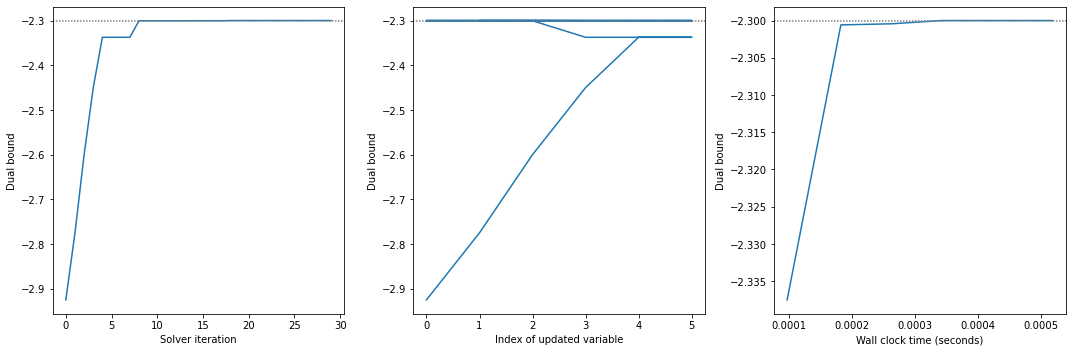

In [ ]:
_, axs = plt.subplots(1, 3, figsize=(15, 5))

# Invert costs to show utilities.
axs[0].plot(
    np.arange(opt_results.objective_at_step.shape[0]),
    opt_results.objective_at_step,
)
axs[0].set_xlabel("Solver iteration")
axs[0].set_ylabel("Dual bound")

axs[1].plot(opt_results.variable_at_step, opt_results.objective_at_step)
axs[1].set_xlabel("Index of updated variable")
axs[1].set_ylabel("Dual bound")

axs[2].plot(opt_results.time_at_sweep, opt_results.objective_at_sweep)
axs[2].set_xlabel("Wall clock time (seconds)")
axs[2].set_ylabel("Dual bound")

axs[0].axhline(y=cost_of_assignment, color="gray", dashes=[1, 1])
axs[1].axhline(y=cost_of_assignment, color="gray", dashes=[1, 1])
axs[2].axhline(y=cost_of_assignment, color="gray", dashes=[1, 1])

plt.tight_layout()

Above, we see that the dual bound increases monotonically as a function of the number of iterations. Ideally, the solver will converge to a tight bound that is exactly equal to the actual cost of the solution. In this case, we have to visit variable 2 twice before we obtain a tight bound.

(In some cases, the solver does not converge. In this case, the subproblems do not fully agree on a solution, but there is no way to increase agreement by passing messages. The optimal solution then must have a cost somewhere between the cost of the particular solution we found and the bound computed by dual decomposition. We could do a more expensive search, but in practice we just use the possibly-suboptimal solution we extracted heuristically.)

If we visualize the matchings again, all subproblems now agree on the optimal assignments after accounting for the penalties. Note also that the path taken by target 0 has changed: if there are no constraints on the SURE and UNSURE tokens, it was better to delete "e" and "f" and keep "a","b","c","d", but if "e" and "f" are the only allowed SURE tokens, it is better to
keep "e" and "f" and delete "a","b","c","d" instead.

In [ ]:
for i in range(len(targets)):
  print(f"Target {i}")
  best_path, assignments = packed_dags.extract_minimal_cost_path_and_assignments(
      system.data.dag_tables[i],
      conversion_data=system.conversion_data[i],
  )
  render_in_notebook.render_dag_in_notebook(
      dag=original_dags[i],
      annotator=SimpleUtilityDiagramAnnotator(),
      emphasized_edges=best_path,
  )

Target 0


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Target 1


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Target 2


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Target 3


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Conclusion

Our full utility functions are based on the same principles as the above steps, but with a few modifications:
- We operate over a tree representation, instead of just sequences.
- We use multiple categories of states and decisions, which allow the utility functions to incorporate additional constraints and account for different types of edit.
- We usually build an extra "constraint" decision diagram with all of the costs as zero, which is just used to constrain the decisions that we can make.
- We carefully set up the decision diagram builder function to make it possible to JIT-compile using numba, which makes this step faster.

For more details on the specific utility functions we used in the paper, check out the notebook [`Utility_decision_diagrams_details.ipynb`](https://colab.research.google.com/github/google-research/r_u_sure/r_u_sure/notebooks/Utility_decision_diagrams_details.ipynb).